In [1]:
import math
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
L = 40  # side length
N = L ** 2  # number of sites
q = 5  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}

## Function Definitions

In [3]:
def energy_nn(sigma, J):
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


def delta_energy_nn(sigma, J, i, j, new_q):
    # i, j = ind
    neighs = [(i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j)]
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


# PRECOMP = 10 ** 6
# precomputed_indexes = [random.randint(0, N - 1) for x in range(PRECOMP)]
# precomp_index = 0


def propose_flip(sigma, J):
    index = random.randint(0, N - 1)
    index1, index2 = index // L, index % L

    x = random.randint(0, q - 1)
    while x == sigma[index1][index2]:
        x = random.randint(0, q - 1)
    return index1, index2, x


# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False

In [25]:
# metropolis simulation. Accept parameters specifying system and simulation config. Store results in global dicts.
random.seed(2212)


def MCMC(L, q, t, nstep, burnin, J=1, freq=1000, keep_history=True):
    # random initial configuration
    # sigma = np.random.randint(0, q, (L, L))

    sigma = [[random.randint(0, q) for _1 in range(L)] for _2 in range(L)]
    en = energy_nn(sigma, J)

    # run a few steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new
            # update energy
            en += delta_en

    mag_state = list(np.bincount(np.array(sigma).reshape(-1), minlength=q))
    mag_avg = max(mag_state)

    en_history[t] = []
    mag_history[t] = []
    avg_t = 0
    # main loop
    for istep in range(nstep):
        # propose random flip
        ind1, ind2, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, ind1, ind2, q_new)

        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[ind1][ind2]
            sigma[ind1][ind2] = q_new

            # update energy
            en += delta_en
            # update magnetization history
            mag_state[q_old] -= 1
            mag_state[q_new] += 1

            # print(max(mag_state))
            # print(mag_state)
            # time.sleep(0.1)
        mag_avg += max(mag_state)

        if istep % 10 == 1:
            # update energy history
            if keep_history:
                en_history[t].append(en)
                mag_history[t].append(max(mag_state))

        avg_t += en
        # if istep % freq == 3:
        #
        #     temp_mag = [0] * q
        #
        #     for v in mag_state[- freq:]:
        #         for ind, val in enumerate(v):
        #             temp_mag[ind] += val
        #     temp_mag = [x / len(mag_state[-freq:]) for x in temp_mag]
        #     mag_history[t].append(temp_mag)

    return avg_t / nstep, mag_avg / nstep / q


## Simulations q=4

In [309]:
q = 4  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
max_mag_avg = []

burnin = 3 * 10 ** 6
nstep = 10 ** 6

# temps for q = 5
temps = [0.3, 0.7, 0.75, 0.78, 0.8, 0.82, 0.84, 0.87, 0.9, 0.95, 1.0, 1.1, 1.2, 1.5]
# temps = [0.3, 10]

tempo = time.time()
for t in temps:
    print(f'temperature: {t}')
    en, mag = MCMC(L, q, t, nstep, burnin, J, keep_history=False)  # seed 42
    avgs.append(en)
    max_mag_avg.append(mag)
    print(f"Passed: {time.time() - tempo}")
    tempo = time.time()

temperature: 0.3
Passed: 2.0009217262268066
temperature: 0.7


KeyboardInterrupt: 

In [8]:
plt.plot(temps, avgs)
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature')
plt.show()

NameError: name 'temps' is not defined

In [9]:
spec_heats = [(avgs[i + 1] - avgs[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
avg_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

plt.plot(avg_temps, spec_heats)
plt.ylabel('Specific Heat')
plt.xlabel('temperature')
plt.title('Specific Heat vs temperature')
plt.show()

NameError: name 'temps' is not defined

In [10]:
plt.plot(temps[3:-2], avgs[3:-2])
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature - zoom on the phase transition')
plt.show()

NameError: name 'temps' is not defined

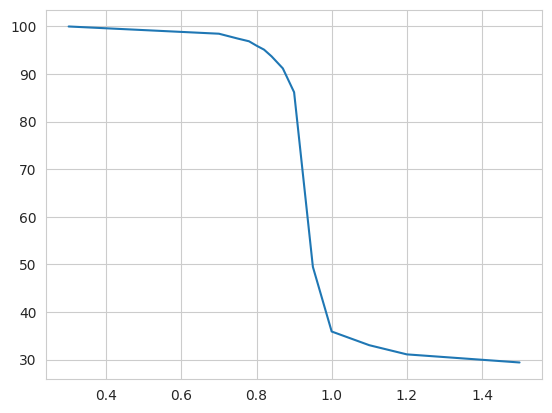

In [295]:
plt.plot(temps, max_mag_avg)
plt.show()

## Simulation q=5

In [190]:
q = 5  # number of states per site
J = 1  # ferromagnetic interaction strength
avgs = []
en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}
# burnin = 7 * 10 ** 5
burnin = 4 * 10 ** 6
# nstep = 5 * 10 ** 6
nstep = 10 ** 7

# temps for q = 5
temps = [0.3, 0.7, 0.75, 0.8, 0.83, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2, 1.5]

tempo = time.time()
for t in temps:
    print(f'temperature: {t}')
    MCMC(L, q, t, nstep, burnin, J, keep_history=False)  # seed 42
    print(f"Passed: {time.time() - tempo}")
    tempo = time.time()

temperature: 0.3
Passed: 42.12368679046631
temperature: 0.7
Passed: 21.776984930038452
temperature: 0.75
Passed: 19.42261552810669
temperature: 0.8
Passed: 21.495123147964478
temperature: 0.83
Passed: 20.155173778533936
temperature: 0.85
Passed: 21.167916297912598
temperature: 0.9
Passed: 24.242859363555908
temperature: 0.95
Passed: 24.276691913604736
temperature: 1.0
Passed: 27.452423334121704
temperature: 1.1
Passed: 28.526541233062744
temperature: 1.2
Passed: 31.316698789596558
temperature: 1.5
Passed: 29.657078981399536


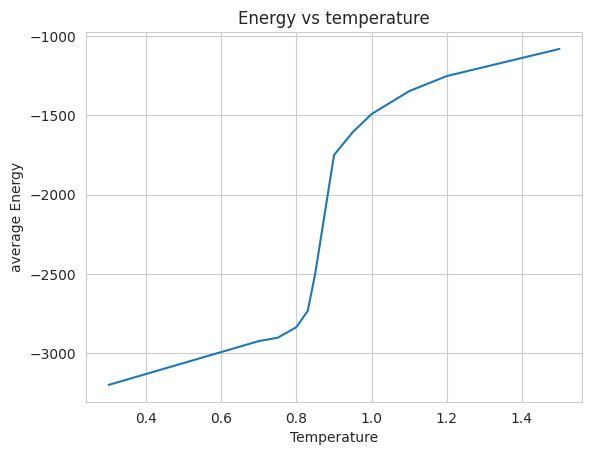

In [191]:
plt.plot(temps, avgs)
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature')
plt.show()

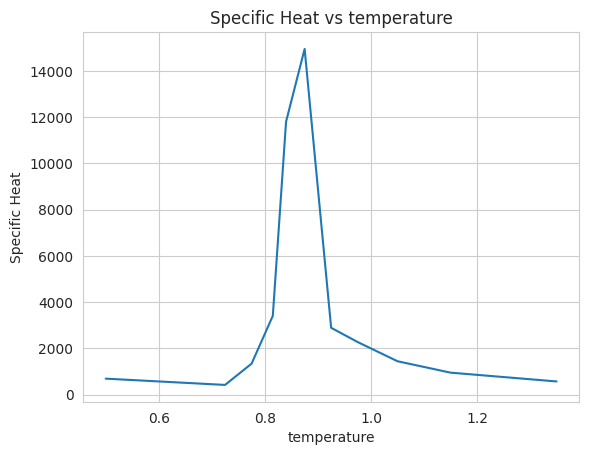

In [192]:
spec_heats = [(avgs[i + 1] - avgs[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
avg_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

plt.plot(avg_temps, spec_heats)
plt.ylabel('Specific Heat')
plt.xlabel('temperature')
plt.title('Specific Heat vs temperature')
plt.show()

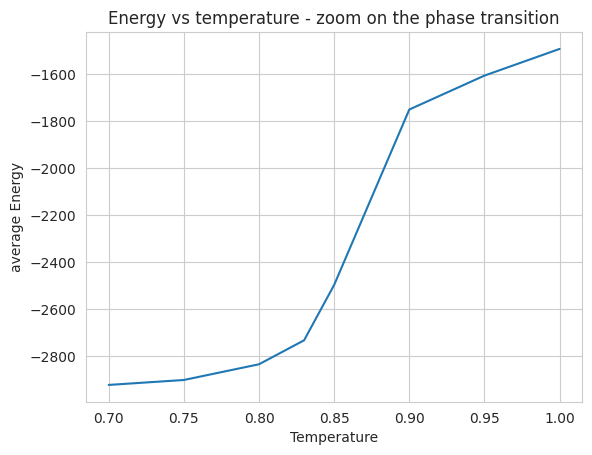

In [193]:
left, right = 1, -3
plt.plot(temps[left:right], avgs[left:right])
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature - zoom on the phase transition')
plt.show()

## Analysis of a single run

In [27]:
import gc
gc.collect()

In [43]:

q = 5
L = 50
N = L ** 2
t = 0.8
avgs = []

en_history = {}
mag_history = {}
prob_history = {}
n_accepted = {}

# burnin = 5 * 10 ** 5
burnin = 3000
nstep = 10 ** 8
MCMC(L, q, t, nstep, burnin, J, keep_history=True)


(-4452.99116593, 456.068722986)

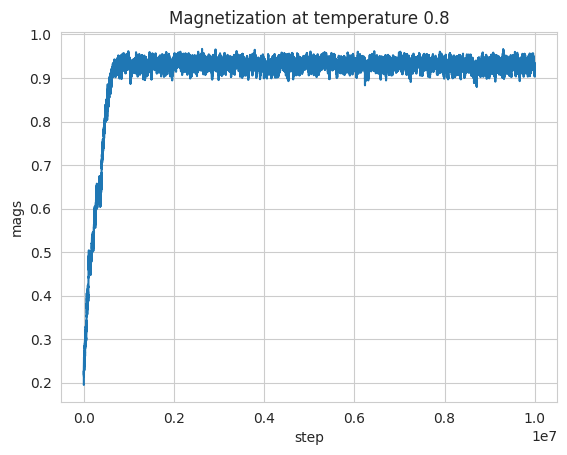

In [44]:
# print magnetization evolution in time
# mag_history[t] = np.array(mag_history[t]).T

# for i in range(q):
#     plt.plot(mag_history[t][i] / N, label=i)

max_mag = np.array(mag_history[t]) / N
plt.plot(max_mag, label='max')

plt.xlabel('step')
plt.ylabel('mags')
plt.title(f"Magnetization at temperature {t}")
plt.show()
# ci starebbe dire che qui il behaviour non è ancora caotico, a .91 L=40 vince una magnetizzazione anche se con tanto rumore.
# a .92 invece è già quasi caotico (tende a vincere una m ma a tratti si flippano e cmq toccano il 66% di solito) q=4

In [45]:
window_size = 3000
kernel = np.ones(window_size) / window_size
# smoothed_en = np.convolve(en_history[t], kernel, mode='valid')

Average energy: -4452.9910263


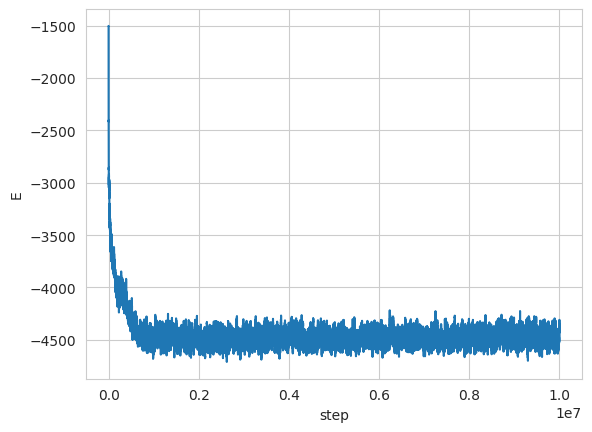

In [46]:

plt.plot(en_history[t])
plt.xlabel("step")
plt.ylabel("E")

# print(f'Average energy: {en_history[t].mean()}')
print(f'Average energy: {sum(en_history[t]) / len(en_history[t])}')
plt.show()

In [42]:
# convolve acceptance probabilities with a kernel to improve visualization

smoothed_probs = np.convolve(prob_history[t], kernel, mode='valid')

KeyError: 0.5

In [ ]:
# plot
plt.plot(smoothed_probs)
plt.xlabel('step')
plt.ylabel('acceptance probability (smoothed)')
# plt.yscale('log')

print(f"Fraction of accepted proposals: {n_accepted[t] / nstep}")
plt.show()


In [ ]:
# t=.92 è il più interessante (o cmq in quella zona) poiché intorno alla transizione ci sono dei flip nelle probabilità e si vedono dei trend
# del tipo che il sistema è in fasi diverse e quindi la acceptance probability anche fa su e giù
# è abbastanza sensibile al seed iniziale

In [255]:
import math


def critical_t(q):
    return 1 / math.log(1 + math.sqrt(q))

In [258]:
for p in [2, 4, 5, 8]:
    print(critical_t(p))

1.134592657106511
0.9102392266268373
0.8515283616124156
0.7449044551221581
